# Importing the Libraries

In [1]:
import os
import numpy as np
from numpy.linalg import norm
import joblib 
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

# Loading the Pretrained Architecture

In [3]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

# Extracting the Features from the Dataset

In [4]:
batch_size = 64
root_dir = 'caltech_dataset'

img_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_generator.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict_generator(datagen, num_epochs)

Found 9201 images belonging to 103 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


# Appliying PCA to Optimise the Results

In [5]:
pca = PCA(n_components=50)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

# Finding the Nearest Neighbours

In [6]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

# Inference Section

In [12]:
img_path = '/home/karthik/Downloads/1639664179530.JPEG'
input_shape = (224, 224, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)


In [13]:
test_img_features = model.predict(preprocessed_img, batch_size=1)


In [14]:
def similar_images(indices):
    filenames = [root_dir + '/' + s for s in datagen.filenames]
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

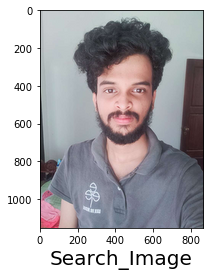

############ Similar Image Predictions ############


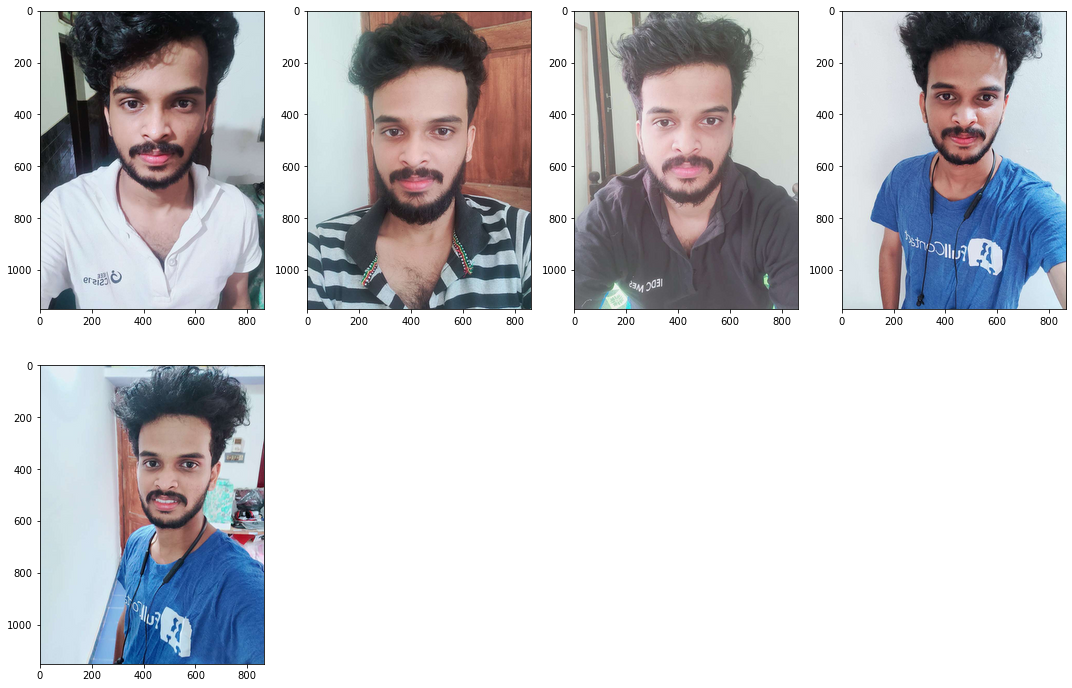

In [15]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel("Search_Image",fontsize=20)
plt.show()
print('############ Similar Image Predictions ############')
similar_images(indices[0])